<a href="https://colab.research.google.com/github/Ngolobe/Forecasting-The-Stock-Market-with-Machine-Learning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Predicting The Stock Market: Keras

##Introduction

On our journey to explore the various machine learning algorithms employed to predict the stock market, we first looked at the use of classic models such as random forests and linear regression. Then we explored some smoothing techniques: these had a limitation of not being able to predict more than one step into the future. Next, we discovered that LSTMs are used to curb this limitations. We implimentated the LSTM with tensorflow but realized that keras does a great job at simplifying the implementation of LSTMs with just a few lines of code. 

In this notebook, we will focus all our effort on learning all we can about how LSTMs are implemented and utilized in **keras**. 

Last but not least, we shall discuss or share our thoughts on our learnings and the way forward or rather the next steps- to be more precise.

Let's first import the necessary libraries!

In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error


#Getting The Data

Let's again run down the data we are going to work with.

We'll be working with data from the S&P500 Index. The S&P500 is a stock market index. Indexes aggregate the prices of multiple stocks together, and allow you to see how the market as a whole is performing. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. The S&P500 Index aggregates the stock prices of 500 large companies.

We'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts. 

Creating a predictive model could allow traders to make money on the stock market.

**NB: You shouldn't make trades with any models developed- on this journey. Trading stocks has risks, and this project does not constitutes stock trading advice.**

Having imported the appropriate tools, we will get market data from Yahoo Finance, a free online source, using pandas.
We'll be using this dataset to develop a predictive model. We'll train the model with data from 1971-2015, and try to make predictions from 2016-2019.

The columns of the dataset are:

* Date -- The date of the record.
* Open -- The opening price of the day (when trading starts).
* High -- The highest trade price during the day.
* Low -- The lowest trade price during the day.
* Close -- The closing price for the day (when trading is finished).
* Volume -- The number of shares traded.
* Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions.


For more information about the columns head over to [this site](https://www.investopedia.com/terms/a/adjusted_closing_price.asp).

In [3]:
# Define the instruments to download. We would like to see the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/1971 until 12/31/2019.
start_date = '1971-01-01'
end_date = '2019-12-31'

# Use pandas_reader.data.DataReader to load the desired data. 
df = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
df = df.reset_index()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1971-01-04,92.190002,90.639999,92.150002,91.150002,10010000,91.150002
1,1971-01-05,92.279999,90.690002,91.150002,91.800003,12600000,91.800003
2,1971-01-06,93.000000,91.500000,91.800003,92.349998,16960000,92.349998
3,1971-01-07,93.260002,91.750000,92.349998,92.379997,16460000,92.379997
4,1971-01-08,93.019997,91.599998,92.379997,92.190002,14100000,92.190002


In [4]:
#check the data types of all the other columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12359 entries, 0 to 12358
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       12359 non-null  datetime64[ns]
 1   High       12359 non-null  float64       
 2   Low        12359 non-null  float64       
 3   Open       12359 non-null  float64       
 4   Close      12359 non-null  float64       
 5   Volume     12359 non-null  int64         
 6   Adj Close  12359 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 676.0 KB


##Data Visualization

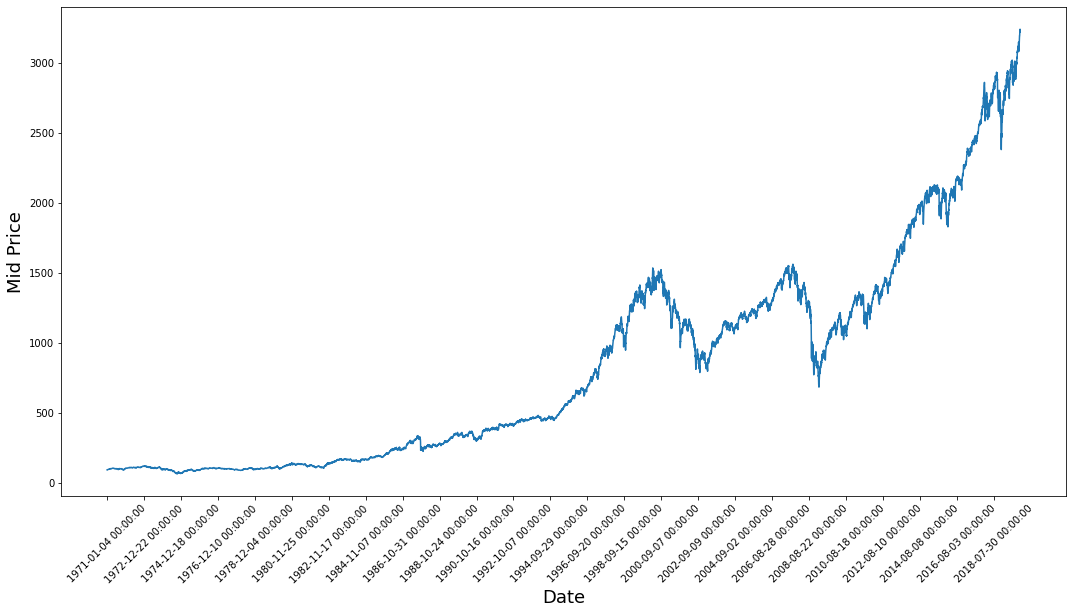

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

##Splitting Data into a Training set and a Test set

In [6]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [7]:
# 12359 is the length of our data frame
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

####Normalizing the Data

In [8]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler(feature_range=(0,1))
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [9]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [10]:
print(type(train_data))
print(len(train_data))

<class 'numpy.ndarray'>
11000


In [11]:
train_data

array([[0.37679114],
       [0.37769071],
       [0.38752171],
       ...,
       [0.93245122],
       [0.92673666],
       [0.92371196]])

##Incorporating Timesteps Into Data

It's required that we should input our data in the form of a 3D array to the LSTM model. First, we create data in 60 timesteps before using numpy to convert it into an array. Finally, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [12]:
X_train = []
y_train = []
for i in range(60, len(train_data)):
  X_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
y_train

array([0.48885182, 0.49187181, 0.49110069, ..., 0.93245122, 0.92673666,
       0.92371196])

##Creating the LSTM Model

Before we can develop the LSTM, we have to make a few imports from **Keras**: **Sequential** for initializing the neural network, **LSTM** to add the LSTM layer, **Dropout** for preventing overfitting with dropout layers, and **Dense** to add a densely connected neural network layer.

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

The LSTM layer is added with the following arguments: **200 units** is the dimensionality of the output space, **return_sequences=True** is necessary for stacking LSTM layers so the consequent LSTM layer has a three-dimensional sequence input, and **input_shape** is the shape of the training dataset.

Specifying 0.1 in the Dropout layer means that 10% of the layers will be dropped. Following the LSTM and Dropout layers, we add the Dense layer that specifies an output of one unit. To compile our model we shall use the **Adam** optimizer and set the loss as the **mean_squared_error**. After that, we fit the model to run for 20 epochs with a batch size of 32.

In [30]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
History = model.fit(X_train,y_train,epochs=20,batch_size=32,validation_split=0.2,verbose=2)

Epoch 1/20
274/274 - 5s - loss: 0.0085 - val_loss: 0.0026
Epoch 2/20
274/274 - 4s - loss: 0.0033 - val_loss: 0.0025
Epoch 3/20
274/274 - 4s - loss: 0.0023 - val_loss: 0.0026
Epoch 4/20
274/274 - 4s - loss: 0.0022 - val_loss: 0.0017
Epoch 5/20
274/274 - 4s - loss: 0.0019 - val_loss: 0.0012
Epoch 6/20
274/274 - 4s - loss: 0.0017 - val_loss: 0.0025
Epoch 7/20
274/274 - 4s - loss: 0.0014 - val_loss: 9.3133e-04
Epoch 8/20
274/274 - 4s - loss: 0.0014 - val_loss: 0.0010
Epoch 9/20
274/274 - 4s - loss: 0.0013 - val_loss: 9.9928e-04
Epoch 10/20
274/274 - 4s - loss: 0.0011 - val_loss: 6.8215e-04
Epoch 11/20
274/274 - 4s - loss: 9.9240e-04 - val_loss: 6.4816e-04
Epoch 12/20
274/274 - 4s - loss: 9.6092e-04 - val_loss: 6.0497e-04
Epoch 13/20
274/274 - 4s - loss: 9.7229e-04 - val_loss: 0.0011
Epoch 14/20
274/274 - 4s - loss: 8.9115e-04 - val_loss: 5.6919e-04
Epoch 15/20
274/274 - 4s - loss: 8.4253e-04 - val_loss: 5.2433e-04
Epoch 16/20
274/274 - 4s - loss: 8.2796e-04 - val_loss: 4.8759e-04
Epoch 17/

##Plot Training History

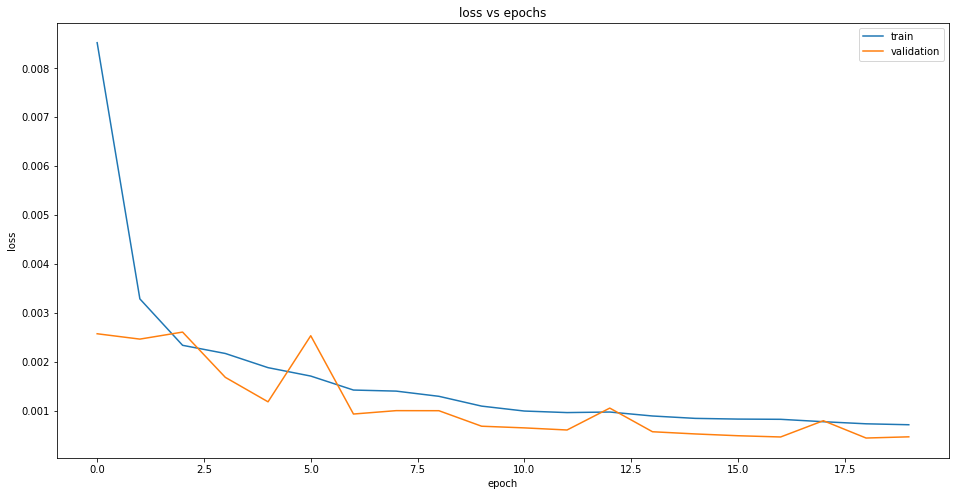

In [31]:
# ###-----plot accuracy-----------
# # plot training accuracy
# plt.figure(figsize=(16,8))
# plt.plot(History.history['accuracy'])
# # plot validation accuracy
# plt.plot(History.history['val_accuracy'])
# # set title
# plt.title('accuracy vs epoch')
# # set x and y axis labels
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# # set the legend
# plt.legend(['train', 'validation'], loc='upper left')
# # display the plot
# plt.show()

###-----plot loss---------------
# plot training loss
plt.figure(figsize=(16,8))
plt.plot(History.history['loss'])
# plot validation loss
plt.plot(History.history['val_loss'])
# set title
plt.title('loss vs epochs')
# set x and y axis labels
plt.ylabel('loss')
plt.xlabel('epoch')
# set the legend
plt.legend(['train', 'validation'], loc='upper right')
# display the plot
plt.show()

#Model Performance

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

##Making Predictions on the Test Set

Before predicting future stock prices, we set 60 as the time step again, use **MinMaxScaler**, and reshape data. Then, **inverse_transform** puts the stock prices in a normal readable format.

In [32]:
dataset_total = mid_prices
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
  X_test.append(inputs[i-60:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [33]:
predicted_stock_price

array([[ 133.82161],
       [ 195.21019],
       [ 375.22684],
       ...,
       [2942.1743 ],
       [3042.2837 ],
       [2932.465  ]], dtype=float32)

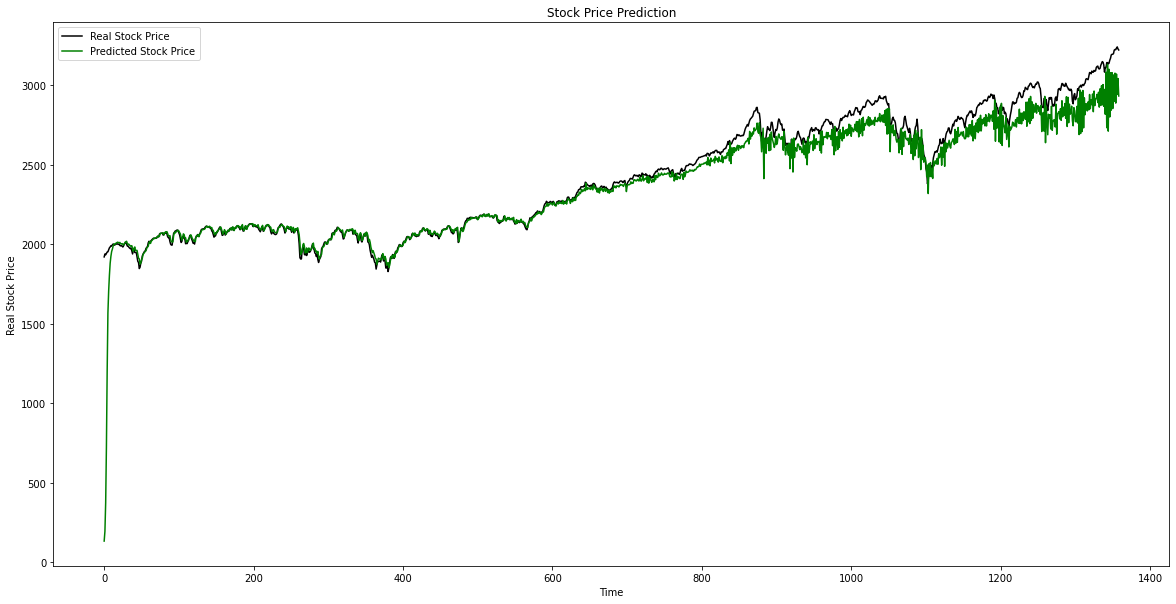

In [34]:
#plot the predicted values alongside the real stock values
plt.figure(figsize=(20,10))
plt.plot(test_data, color = 'black', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
#set title
plt.title('Stock Price Prediction')
# set x and y axis labels
plt.xlabel('Time')
plt.ylabel('Real Stock Price')
# set legend
plt.legend()
# display the plot
plt.show()

In [35]:
#compute the root mean square error, RMSE
testScore = math.sqrt(mean_squared_error(test_data, predicted_stock_price))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 120.50 RMSE


In [36]:
print(test_data.shape)
print(predicted_stock_price.shape)

(1359, 1)
(1359, 1)


##Making Predictions On The Train Set

In [37]:
predicted_X_train = model.predict(X_train)
predicted_X_train = scaler.inverse_transform(predicted_X_train)

In [38]:
predicted_X_train

array([[1513.7546],
       [1515.9406],
       [1517.8365],
       ...,
       [1951.1257],
       [1944.7915],
       [1938.5883]], dtype=float32)

In [39]:
#transform the training target values, y_train, into a normal readable format
real_X_train = scaler.inverse_transform([y_train])
real_X_train

array([[1507.81426362, 1510.65480706, 1509.9295011 , ..., 1925.05499268,
        1919.67999268, 1916.83502197]])

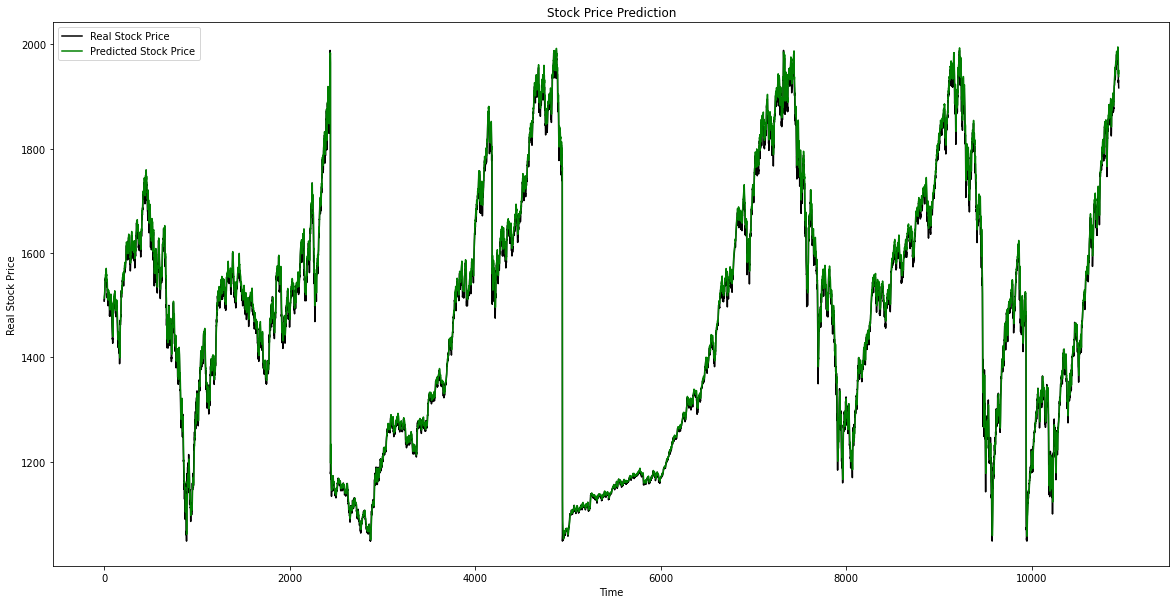

In [40]:
#to take a look at our results we plot the predicted values alongside the actual values below
#plot the predicted values alongside the real stock values
plt.figure(figsize=(20,10))
plt.plot(real_X_train.T, color = 'black', label = 'Real Stock Price')
plt.plot(predicted_X_train, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Real Stock Price')
plt.legend()
plt.show()

In [41]:
# compute the Root Mean Square Error
trainScore = math.sqrt(mean_squared_error(predicted_X_train, real_X_train.T))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 17.99 RMSE


In [42]:
History.history.keys()

dict_keys(['loss', 'val_loss'])

##Model Accuracy

In [43]:
#fot the model accuracy we decided to use the Root Mean Square Percentage Error 
rmspe = (np.sqrt(np.mean(np.square((test_data - predicted_stock_price) / test_data)))) * 100
print('Root Mean Square Percentage Error: %.2f '% (rmspe)+'%')
print( 'Model Accuracy: %.2f '% (100-rmspe)+'%')

Root Mean Square Percentage Error: 5.42 %
Model Accuracy: 94.58 %


##Next Steps

For an intuitive guide to LSTMs follow this [link](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

We can improve the performance of our model by taking some of the following measures:
* Try out different Activation Functions.
* Try out different Batches and Epochs.
* Experiment with various Regularization techniques.
* Examine different Optimization functions.

Last but not least, in the future we will investigate the performace of GRUs because it is believed that GRU is simpler than LSTM, GRUs will take much less time to train and are more efficient.